In [23]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### unzip data files

In [2]:
from zipfile import ZipFile

zf = ZipFile('KingHaraldsCovidQuest.zip')
zf.extractall()
zf.close()

In [3]:
%%time
import datatable as dt
import pandas as pd
import os

folder_name = 'KingHaraldsCovidQuest'
df_dict = {}
for csv_name in os.listdir(folder_name):
    df_holder = dt.fread(f'{folder_name}\{csv_name}').to_pandas()
    df_dict[csv_name] = df_holder

Wall time: 1.52 s


#### Generate EDA html files with pandas_profiling

In [4]:
from pandas_profiling import ProfileReport
import shutil

generate_pd_prof, output_in_cell = False, False
pd_prof_dir = 'pd_prof_html'
if generate_pd_prof:
    if os.path.exists(pd_prof_dir):
        shutil.rmtree(pd_prof_dir)
    os.mkdir(pd_prof_dir)
    for df_name in list(df_dict.keys()):
        pd_prof = ProfileReport(df_dict[df_name])
        if output_in_cell:
            pd_prof.to_notebook.iframe()
        else:
            df_name_no_csv = df_name.replace('.csv','')
            pd_prof.to_file(output_file=f'{pd_prof_dir}\{df_name_no_csv}.html')

#### I have chosen to work with the ReportedCovidCasesByDay.csv as a time series problem

In [5]:
import platform
import pystan

dependencies_installed = True
if platform.system() == 'Windows' and not dependencies_installed:
    os.system("conda install libpython m2w64-toolchain -c msys2 --yes")
    model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
    model = pystan.StanModel(model_code=model_code)  # this will take a minute
    y = model.sampling(n_jobs=1).extract()['y']
    print(y.mean())  # should be close to 0

In [6]:
from kats.consts import TimeSeriesData

daily_cases_df = df_dict['ReportedCovidCasesByDay.csv']
# daily_cases_df.columns.to_list()
# we will model new cases as opposed to cumulative
daily_cases_df = daily_cases_df.iloc[:,[0,2]]
daily_cases_df.columns = ['time','value']
daily_cases_df = daily_cases_df.sort_values(by='time',ascending=True).fillna(method='ffill').fillna(method='bfill')
daily_cases_ts = TimeSeriesData(daily_cases_df)

In [24]:
from kats.tsfeatures.tsfeatures import TsFeatures

features_model = TsFeatures()
output_features = features_model.transform(daily_cases_ts)
df_univariate_features = pd.DataFrame([output_features])
df_univariate_features

,length,mean,var,entropy,lumpiness,stability,flat_spots,hurst,std1st_der,crossing_points,...,diff2y_pacf5,seas_acf1,seas_pacf1,firstmin_ac,firstzero_ac,holt_alpha,holt_beta,hw_alpha,hw_beta,hw_gamma
0,497,264.603622,62970.577291,0.603834,3.476023e+08,35081.563932,4,0.080871,108.478532,67,...,0.779057,0.536735,0.017805,5,137,0.542057,0.068925,NaN,NaN,NaN


#### checks for stationarity for arima, sarima, holts winters models

ADF Stat: -3.644017713934077
p-value: 0.0049731672429263775


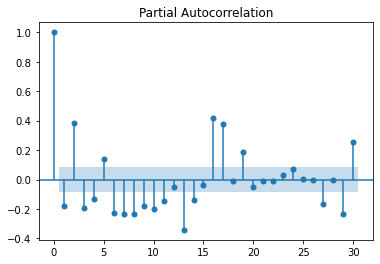

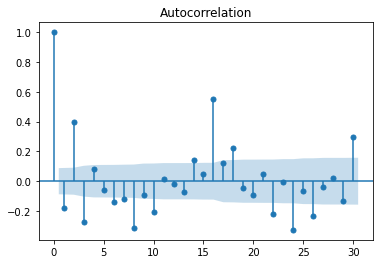

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller


daily_cases_df_copy = daily_cases_df.copy()
# daily_cases_df_copy['diff_value'] = daily_cases_df_copy['value'].diff()
# daily_cases_df_copy = daily_cases_df_copy.drop(daily_cases_df_copy.index[0])
plot_pacf(daily_cases_df_copy['value'],lags=30);
plot_acf(daily_cases_df_copy['value'],lags=30);
ad_fuller_result = adfuller(daily_cases_df_copy['value'])
print(f'ADF Stat: {ad_fuller_result[0]}\np-value: {ad_fuller_result[1]}')

#### Not stationary will avoid arima based models for now

INFO:root:Setting frequency to Daily since it cannot be inferred
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:root:Generated forecast data from Prophet model.
INFO:root:Generated forecast data from Prophet model.
INFO:root:Generating chart for forecast result from Ensemble model.
INFO:root:Generating chart for forecast result.


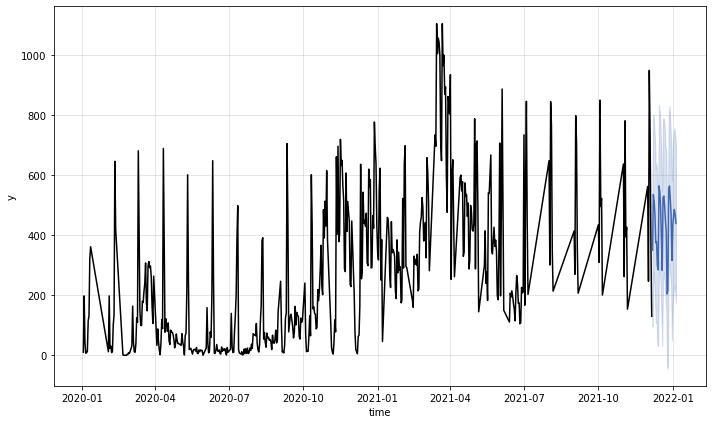

In [9]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (arima,sarima,holtwinters,linear_model,quadratic_model,theta,prophet,lstm)

model_params = EnsembleParams(
    [
        BaseModelParams('prophet',prophet.ProphetParams(
            growth="linear",
            changepoints=None,
            n_changepoints=10,
            changepoint_range=0.8,
            yearly_seasonality="auto",
            weekly_seasonality="auto",
            daily_seasonality="auto",
            holidays=None,
            seasonality_mode="additive",
            seasonality_prior_scale=20.0,
            holidays_prior_scale=10.0,
            changepoint_prior_scale=0.1,
            mcmc_samples=0,
            interval_width=0.80,
            uncertainty_samples=1000,
            cap=None,
            floor=None
        )),
    ]
)
KatsEnsembleParam = {
    'models':model_params,
    'aggregation':'median',
    'seasonality_length':12,
    'decomposition_method':'additive',
}
model = KatsEnsemble(data=daily_cases_ts,params=KatsEnsembleParam)
model.fit()
num_pred_steps = 30
fcst = model.predict(steps=num_pred_steps)
model.aggregate()
model.plot()

#### I have created a prophet model in hopes of assisting King Harald predict new cases so hospitals can accomodate

In [10]:
import matplotlib.pyplot as plt

def adjusted_Kats_plot(filtered_date_ts,plot_fcst,ylabel,value_col='value'):
    fig = plt.figure(facecolor="w", figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(pd.to_datetime(filtered_date_ts.time), filtered_date_ts[value_col], "k")
    last_date = filtered_date_ts.time.max()
    freq = pd.infer_freq(filtered_date_ts.time)
    steps = plot_fcst.shape[0]
    dates = pd.date_range(start=last_date, periods=num_pred_steps + 1, freq=freq)
    dates_to_plot = dates[dates != last_date]
    fcst_dates = dates_to_plot.to_pydatetime()
    ax.plot(fcst_dates, plot_fcst.fcst, ls="-", c="#4267B2")
    if ("fcst_lower" in plot_fcst.columns) and ("fcst_upper" in plot_fcst.columns):
        ax.fill_between(
            fcst_dates,
            plot_fcst.fcst_lower,
            plot_fcst.fcst_upper,
            color="#4267B2",
            alpha=0.2,
        )
    ax.grid(True, which="major", c="gray", ls="-", lw=1, alpha=0.2)
    ax.set_xlabel(xlabel="time")
    ax.set_ylabel(ylabel=ylabel)
    fig.tight_layout()
    plt.show()

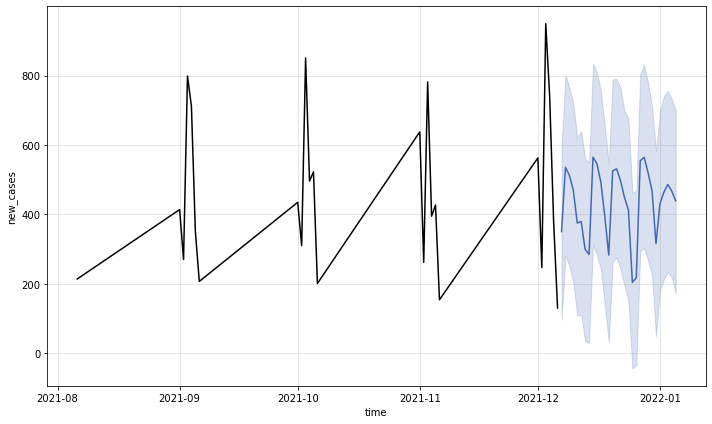

In [11]:
max_date_daily_cases = max(daily_cases_ts.to_dataframe()['time'])
date_mask = pd.to_datetime(max_date_daily_cases).floor('D') - pd.offsets.DateOffset(months=4)
plot_df = daily_cases_df[pd.to_datetime(daily_cases_df['time']) >= date_mask]
adjusted_Kats_plot(filtered_date_ts=plot_df,plot_fcst=fcst.fcst_df,ylabel='new_cases')

,AgeGroup,Female,Male
0,0-9,5588,5940
1,10-19,10980,11458
2,20-29,12560,14507
3,30-39,9899,12121
4,40-49,9288,10868
5,50-59,7057,8677
6,60-69,3075,4051
7,70-79,1596,1800
8,80-89,881,637
9,90+,384,141


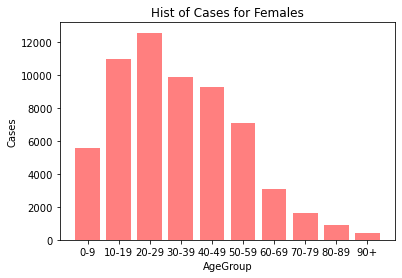

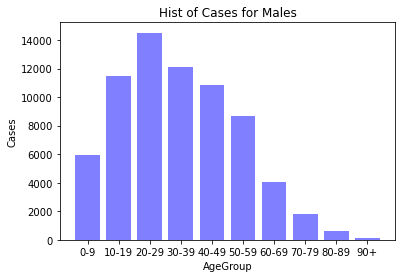

In [21]:
from IPython.display import display
age_gender_df = df_dict['CovidCasesByAgeGenderTotal.csv']
age_gender_df.columns = [colname.replace('\"','') for colname in age_gender_df.columns.to_list()]
display(age_gender_df)
for gender in [colname for colname in list(age_gender_df.columns) if colname not in ('AgeGroup')]:
    color_dict = {'Female':'red','Male':'blue'}
    plt.bar(age_gender_df['AgeGroup'],age_gender_df[gender], align='center',alpha=0.5,color=color_dict[gender])
    plt.title(f'Hist of Cases for {gender}s')
    plt.xlabel('AgeGroup')
    plt.ylabel('Cases')
    plt.show();